# E2VID Video Reconstruction from Event Data

This notebook demonstrates how to use evlib's E2VID model to reconstruct video sequences from event camera data.

We'll show:
1. Loading event data
2. Creating an E2VID model 
3. Reconstructing individual frames
4. Creating a video sequence
5. Displaying the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Video
import cv2
import os
from pathlib import Path

import evlib
import evlib.models

print(f"evlib version: {evlib.version}")
print("Libraries loaded successfully!")

evlib version: <built-in function version>
Libraries loaded successfully!


## 1. Load Event Data

First, let's load some event data and examine its properties.

In [2]:
# Load a portion of event data for video reconstruction
data_path = '../data/slider_depth/events.txt'

# Load all events first to understand the temporal range
all_events = evlib.load_events(data_path)
events_df = all_events.collect()

print(f"Total events: {len(events_df)}")
print(f"Spatial resolution: {events_df['x'].max()+1} x {events_df['y'].max()+1}")

# Convert timestamp to seconds for easier handling
timestamps_sec = events_df['timestamp'].to_numpy().astype(np.float64) / 1e6
duration = timestamps_sec.max() - timestamps_sec.min()
print(f"Duration: {duration:.3f} seconds")
print(f"Event rate: {len(events_df)/duration:.0f} events/second")

Total events: 1078541
Spatial resolution: 240 x 180
Duration: 3.400 seconds
Event rate: 317193 events/second


## 2. Initialize E2VID Model

Create the E2VID model for frame reconstruction.

In [3]:
# Create E2VID model
print("Initializing E2VID model...")
model = evlib.models.E2VID(pretrained=True)
print(f"Model: {model}")
print("Model ready for reconstruction!")

Initializing E2VID model...
Loading pretrained weights from e2vid-lite.pth
Adjusting num_encoders: 4 → 3 (pretrained model is 'lite' variant)
Detected normalization layers, enabling batch normalization (pretrained model uses BN)
Detected TransposedConv layers, adjusting architecture for pretrained compatibility
✓ Pretrained weights loaded successfully (40/72 parameters)
Model: E2VID(config=ModelConfig(in_channels=5, out_channels=1, base_channels=32, num_layers=4, num_bins=5, use_gpu=True, extra_params={}), pretrained=True, skip_type='sum', encoders=3, residual_blocks=2, norm='BN', device=cpu)
Model ready for reconstruction!


## 3. Single Frame Reconstruction

Let's first reconstruct a single frame to understand the process.

Reconstructing single frame...
Reconstructed frame shape: (180, 240)
Frame intensity range: [0.2931, 0.6850]


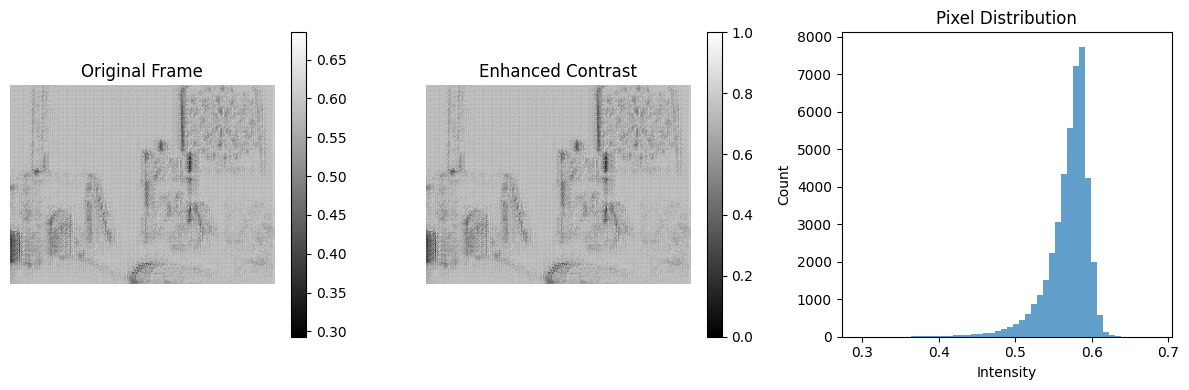

In [4]:
# Reconstruct a single frame from the first 100ms of data
start_time = timestamps_sec.min()
single_frame_events = evlib.load_events(data_path, t_start=start_time, t_end=start_time + 0.1)

print("Reconstructing single frame...")
frame = model.reconstruct(single_frame_events)

print(f"Reconstructed frame shape: {frame.shape}")
print(f"Frame intensity range: [{frame.min():.4f}, {frame.max():.4f}]")

# Visualize the single frame
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(frame, cmap='gray')
plt.title('Original Frame')
plt.colorbar()
plt.axis('off')

# Enhanced contrast
frame_enhanced = (frame - frame.min()) / (frame.max() - frame.min())
plt.subplot(1, 3, 2)
plt.imshow(frame_enhanced, cmap='gray')
plt.title('Enhanced Contrast')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.hist(frame.flatten(), bins=50, alpha=0.7)
plt.title('Pixel Distribution')
plt.xlabel('Intensity')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Video Sequence Reconstruction

Now let's reconstruct a sequence of frames to create a video.

In [5]:
# Parameters for video reconstruction
frame_duration = 0.05  # 50ms per frame (20 FPS)
video_duration = 1.0   # Total video duration in seconds
start_time = timestamps_sec.min()

# Calculate number of frames
num_frames = int(video_duration / frame_duration)
print(f"Reconstructing {num_frames} frames at {1/frame_duration:.0f} FPS")
print(f"Frame duration: {frame_duration*1000:.0f}ms")

# Reconstruct frames
frames = []
frame_times = []

for i in range(num_frames):
    t_start = start_time + i * frame_duration
    t_end = t_start + frame_duration
    
    # Load events for this time window
    frame_events = evlib.load_events(data_path, t_start=t_start, t_end=t_end)
    
    # Skip if no events in this window
    events_count = len(frame_events.collect())
    if events_count == 0:
        print(f"Frame {i+1}/{num_frames}: No events, skipping...")
        continue
        
    # Reconstruct frame
    frame = model.reconstruct(frame_events)
    
    # Enhance contrast for better visualization
    frame_enhanced = (frame - frame.min()) / (frame.max() - frame.min())
    frames.append(frame_enhanced)
    frame_times.append(t_start)
    
    print(f"Frame {i+1}/{num_frames}: {events_count:,} events, t={t_start:.3f}s")

print(f"\nSuccessfully reconstructed {len(frames)} frames")

Reconstructing 20 frames at 20 FPS
Frame duration: 50ms
Frame 1/20: 11,608 events, t=0.004s
Frame 2/20: 15,786 events, t=0.054s
Frame 3/20: 16,157 events, t=0.104s
Frame 4/20: 16,120 events, t=0.154s
Frame 5/20: 14,384 events, t=0.204s
Frame 6/20: 14,449 events, t=0.254s
Frame 7/20: 15,840 events, t=0.304s
Frame 8/20: 14,096 events, t=0.354s
Frame 9/20: 14,647 events, t=0.404s
Frame 10/20: 14,908 events, t=0.454s
Frame 11/20: 15,251 events, t=0.504s
Frame 12/20: 15,392 events, t=0.554s
Frame 13/20: 16,084 events, t=0.604s
Frame 14/20: 17,109 events, t=0.654s
Frame 15/20: 16,359 events, t=0.704s
Frame 16/20: 16,890 events, t=0.754s
Frame 17/20: 17,232 events, t=0.804s
Frame 18/20: 16,699 events, t=0.854s
Frame 19/20: 16,125 events, t=0.904s
Frame 20/20: 17,170 events, t=0.954s

Successfully reconstructed 20 frames


## 5. Display Frame Sequence

Let's first look at a few sample frames from our sequence.

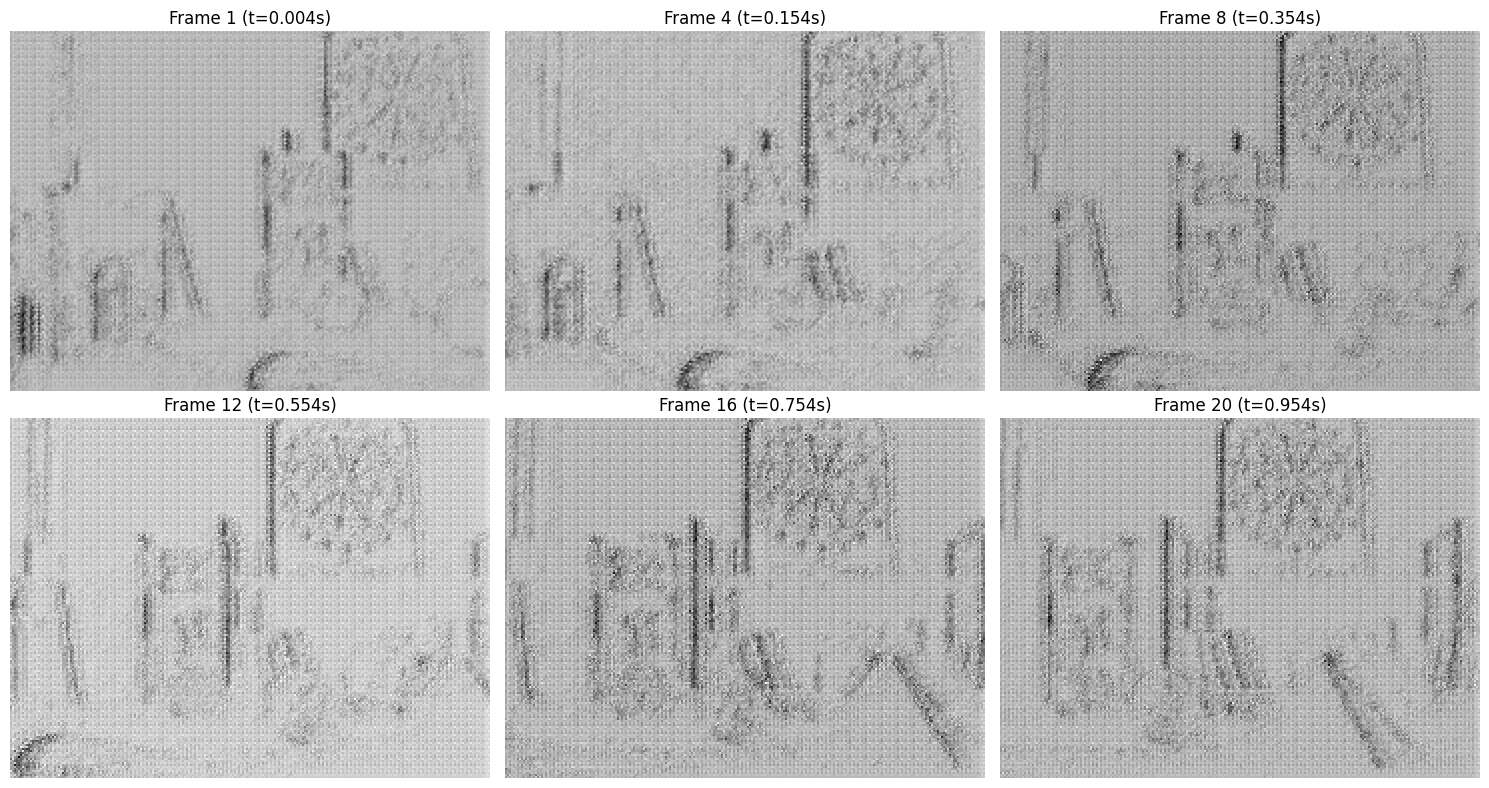

In [6]:
# Display a grid of sample frames
if len(frames) >= 6:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    sample_indices = np.linspace(0, len(frames)-1, 6, dtype=int)
    
    for idx, ax in zip(sample_indices, axes.flat):
        ax.imshow(frames[idx], cmap='gray')
        ax.set_title(f'Frame {idx+1} (t={frame_times[idx]:.3f}s)')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Only {len(frames)} frames available for display")
    for i, frame in enumerate(frames[:3]):
        plt.figure(figsize=(8, 6))
        plt.imshow(frame, cmap='gray')
        plt.title(f'Frame {i+1} (t={frame_times[i]:.3f}s)')
        plt.colorbar()
        plt.axis('off')
        plt.show()

## 6. Create Matplotlib Animation

Display the frames as an animated sequence.

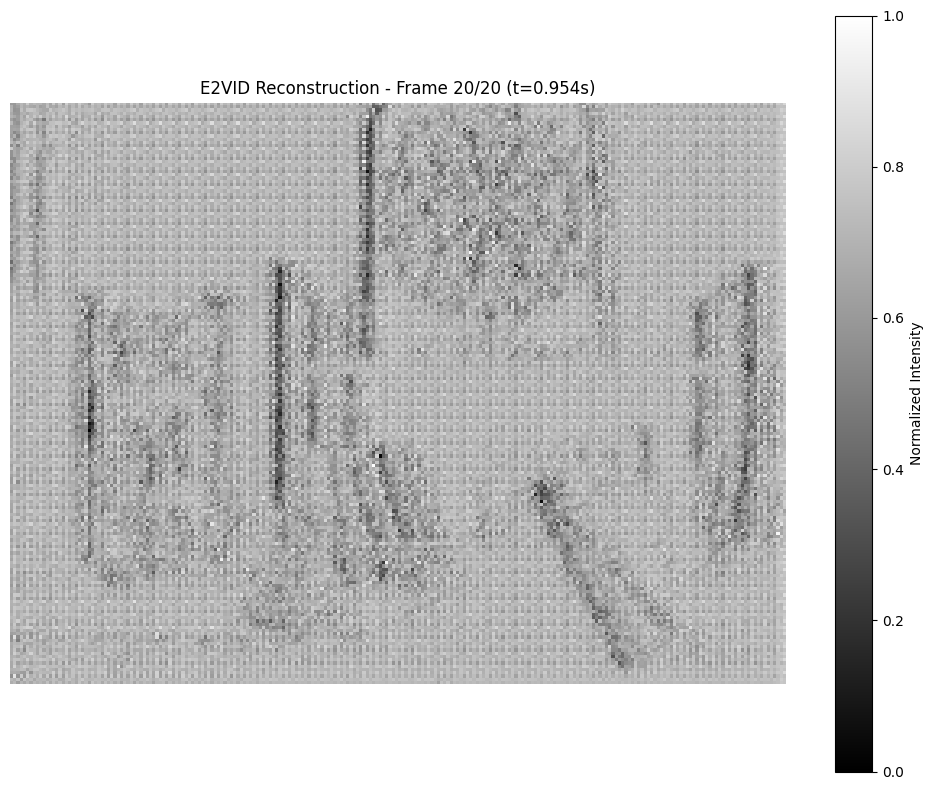

In [8]:
if len(frames) > 1:
    # Create animation
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Initialize the plot
    im = ax.imshow(frames[0], cmap='gray', animated=True)
    ax.set_title('E2VID Video Reconstruction')
    ax.axis('off')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Intensity')
    
    # Animation function
    def animate(frame_idx):
        im.set_array(frames[frame_idx])
        ax.set_title(f'E2VID Reconstruction - Frame {frame_idx+1}/{len(frames)} (t={frame_times[frame_idx]:.3f}s)')
        return [im]
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), 
        interval=int(frame_duration*1000),  # Convert to milliseconds
        blit=True, repeat=True
    )
    
    # Display in notebook
    plt.tight_layout()
    HTML(anim.to_jshtml())
else:
    print("Not enough frames for animation")

## 7. Save as Video File

Create an MP4 video file from the reconstructed frames.

In [9]:
if len(frames) > 1:
    # Create output directory
    output_dir = Path('figures')
    output_dir.mkdir(exist_ok=True)
    
    video_path = output_dir / 'e2vid_reconstruction.mp4'
    
    # Video parameters
    fps = int(1 / frame_duration)
    height, width = frames[0].shape
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(str(video_path), fourcc, fps, (width, height), isColor=False)
    
    print(f"Creating video: {video_path}")
    print(f"Resolution: {width}x{height}, FPS: {fps}")
    
    # Write frames
    for i, frame in enumerate(frames):
        # Convert to 8-bit grayscale
        frame_8bit = (frame * 255).astype(np.uint8)
        video_writer.write(frame_8bit)
        
    video_writer.release()
    print(f"Video saved successfully: {video_path}")
    
    # Display video info
    file_size = os.path.getsize(video_path) / 1024  # KB
    print(f"File size: {file_size:.1f} KB")
    print(f"Duration: {len(frames)/fps:.2f} seconds")
    
    # Try to display the video in the notebook
    try:
        display(Video(str(video_path), width=width*2, height=height*2))
    except Exception as e:
        print(f"Could not display video inline: {e}")
        print(f"Video saved at: {video_path.absolute()}")
        
else:
    print("Not enough frames to create video")

Creating video: figures/e2vid_reconstruction.mp4
Resolution: 240x180, FPS: 20
Video saved successfully: figures/e2vid_reconstruction.mp4
File size: 305.2 KB
Duration: 1.00 seconds


## 8. Performance Analysis

Let's analyze the reconstruction performance.


RECONSTRUCTION PERFORMANCE SUMMARY
Total frames reconstructed: 20
Frame resolution: 240x180
Target FPS: 20.0
Actual FPS: 21.1
Frame duration: 50ms
Total video duration: 0.95s

FRAME QUALITY METRICS:
Average intensity: 0.7029 ± 0.0282
Average contrast: 1.0000 ± 0.0000


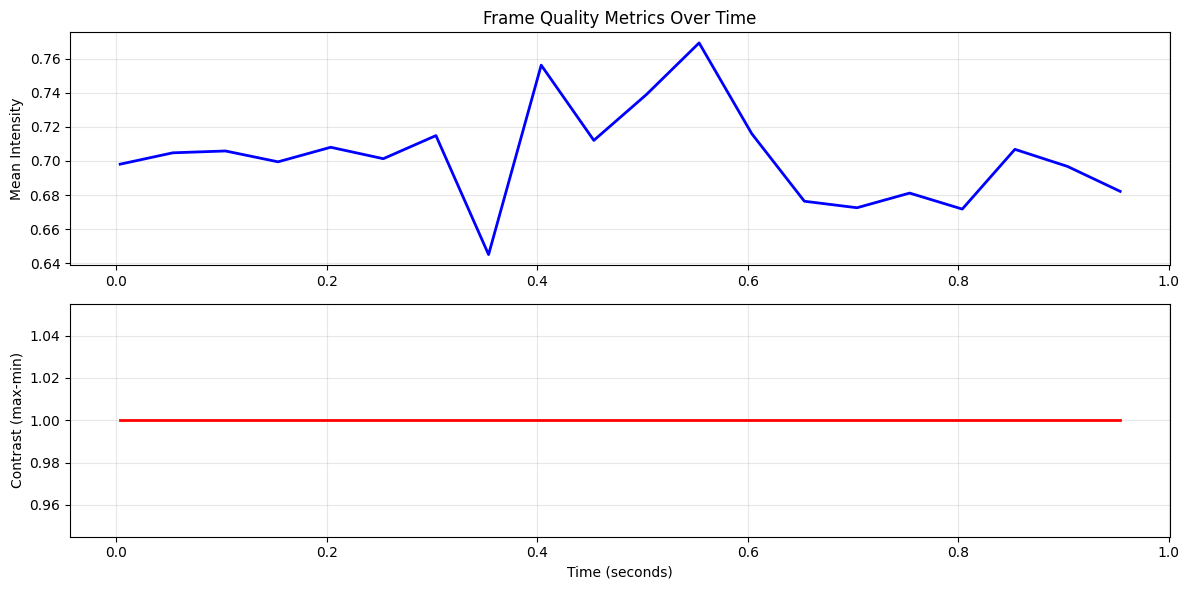

In [10]:
if len(frames) > 0:
    # Calculate statistics
    total_duration = frame_times[-1] - frame_times[0] if len(frame_times) > 1 else frame_duration
    actual_fps = len(frames) / total_duration if total_duration > 0 else 0
    
    print("\n" + "="*50)
    print("RECONSTRUCTION PERFORMANCE SUMMARY")
    print("="*50)
    print(f"Total frames reconstructed: {len(frames)}")
    print(f"Frame resolution: {frames[0].shape[1]}x{frames[0].shape[0]}")
    print(f"Target FPS: {1/frame_duration:.1f}")
    print(f"Actual FPS: {actual_fps:.1f}")
    print(f"Frame duration: {frame_duration*1000:.0f}ms")
    print(f"Total video duration: {total_duration:.2f}s")
    
    # Frame quality statistics
    intensities = [frame.mean() for frame in frames]
    contrasts = [(frame.max() - frame.min()) for frame in frames]
    
    print(f"\nFRAME QUALITY METRICS:")
    print(f"Average intensity: {np.mean(intensities):.4f} ± {np.std(intensities):.4f}")
    print(f"Average contrast: {np.mean(contrasts):.4f} ± {np.std(contrasts):.4f}")
    
    # Plot quality metrics over time
    if len(frames) > 3:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
        
        # Intensity over time
        ax1.plot(frame_times, intensities, 'b-', linewidth=2)
        ax1.set_ylabel('Mean Intensity')
        ax1.set_title('Frame Quality Metrics Over Time')
        ax1.grid(True, alpha=0.3)
        
        # Contrast over time
        ax2.plot(frame_times, contrasts, 'r-', linewidth=2)
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Contrast (max-min)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
else:
    print("No frames were reconstructed")

## Conclusion

This notebook demonstrated how to:

1. **Load event camera data** using evlib's high-performance data loading
2. **Initialize E2VID model** with pretrained weights for frame reconstruction
3. **Reconstruct individual frames** from temporal windows of events
4. **Create video sequences** by processing multiple temporal windows
5. **Visualize results** using matplotlib animations and video files
6. **Analyze performance** with quality metrics and timing analysis

### Key Features:
- **High-performance data loading**: Rust backend with Polars integration
- **GPU acceleration**: PyTorch models with CUDA support when available
- **Flexible temporal windowing**: Adjustable frame duration and overlap
- **Multiple output formats**: Matplotlib animations, MP4 videos, and static images

### Next Steps:
- Experiment with different frame durations and overlap strategies
- Try different event camera datasets
- Explore other reconstruction models as they become available
- Optimize parameters for your specific use case

The combination of evlib's high-performance event processing with PyTorch-based deep learning models provides a powerful platform for event camera video reconstruction!